In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 16.3 MB/s eta 0:00:00


In [3]:
import os
import shutil
import yaml

# Paths
source_dir = "/kaggle/input/signboards"  # Original dataset
dest_dir = "/kaggle/working/signboards"  # Destination directory

# Ensure destination exists
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)  # Remove existing dataset to prevent duplication
shutil.copytree(source_dir, dest_dir)  # Copy dataset to new location

# Define subdirectories
sub_dirs = ["train", "valid", "test"]

# Function to update labels
def update_labels(label_file):
    with open(label_file, "r") as file:
        lines = file.readlines()

    updated_lines = []
    for line in lines:
        parts = line.strip().split()
        if parts:  
            parts[0] = str(int(parts[0]) + 80)  # Shift class ID by 80
            updated_lines.append(" ".join(parts))

    with open(label_file, "w") as file:
        file.write("\n".join(updated_lines) + "\n")

# Iterate through label files and update them
for sub in sub_dirs:
    label_path = os.path.join(dest_dir, sub, "labels")
    for label_file in os.listdir(label_path):
        if label_file.endswith(".txt"):
            update_labels(os.path.join(label_path, label_file))

# Define the new data.yaml
data_yaml = {
    "train": "../train/images",
    "val": "../valid/images",
    "test": "../test/images",
    "nc": 154,  # 80 COCO classes + 74 Traffic Sign classes
    "names": [
        # COCO Classes (IDs 0-79)
        "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
        "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
        "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
        "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
        "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
        "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
        "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
        "chair", "couch", "potted plant", "bed", "dining table", "toilet", "TV", "laptop",
        "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster",
        "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
        "hair drier", "toothbrush",
        
        # Traffic Sign Classes (IDs 80-153)
        "-", "0", "Barrier Ahead", "Cattle", "Caution", "Cycle Crossing", "Dangerous Dip",
        "Eating Place", "Falling Rocks", "Ferry", "First Aid Post", "Give Way", "Horn Prohibited",
        "Hospital", "Hump", "Left Hair Pin Bend", "Left Reverse Bend", "Left hand curve",
        "Light Refreshment", "Men at Work", "Narrow Bridge", "Narrow road ahead", "No Parking",
        "No Stopping", "No Thorough Road", "No Thorough SideRoad", "Parking Lot Cars",
        "Parking Lot Cycle", "Parking Lot Scooter and MotorCycle", "Parking This side",
        "Pedestrian Crossing", "Pedestrian Prohibited", "Petrol Pump- Gas Station",
        "Public Telephone", "Resting Place", "Right Hair Pin Bend", "Right Hand Curve",
        "Right Reverse Bend", "Road Wideness Ahead", "Round About", "School Ahead",
        "Slippery Road", "Speed Limit -10-", "Speed Limit -100-", "Speed Limit -110-",
        "Speed Limit -120-", "Speed Limit -130-", "Speed Limit -140-", "Speed Limit -150-",
        "Speed Limit -160-", "Speed Limit -20-", "Speed Limit -25-", "Speed Limit -35-",
        "Speed Limit -45-", "Speed Limit -48-", "Speed Limit -5-", "Speed Limit -50-",
        "Speed Limit -55-", "Speed Limit -60-", "Speed Limit -65-", "Speed Limit -70-",
        "Speed Limit -75-", "Speed Limit -8-", "Speed Limit -80-", "Speed Limit -90-",
        "Speed Limit 3", "Speed Limit 30", "Speed limit -15-", "Speed limit -40-",
        "Steep Ascent", "Steep Desecnt", "Stop", "Straight Prohibitor No Entry", "walking"
    ]
}

# Save the data.yaml file
yaml_path = os.path.join(dest_dir, "data.yaml")
with open(yaml_path, "w") as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

print("✅ Labels updated and dataset saved to /kaggle/working/signboards/")
print("✅ data.yaml updated with 154 classes (80 COCO + 74 Traffic Signs)")


✅ Labels updated and dataset saved to /kaggle/working/signboards/
✅ data.yaml updated with 154 classes (80 COCO + 74 Traffic Signs)


In [4]:
!pip install clearml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.10.1
    Uninstalling PyJWT-2.10.1:
      Successfully uninstalled PyJWT-2.10.1


In [6]:
import clearml
from clearml import Task
clearml.browser_login()

In [7]:
task = Task.init(project_name="VisionAI", task_name="Evaluation of Yolov8n_1")

ClearML Task: created new task id=d4a8d2cac861433f86ed41c314fc862c
2025-03-20 17:26:01,968 - clearml.Repository Detection - WARNING - Failed accessing the jupyter server(s): []
2025-03-20 17:26:04,943 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/b9472298bc3e4a9eaaf2766a7b3b04ca/experiments/d4a8d2cac861433f86ed41c314fc862c/output/log


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 85.5MB/s]


Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/signboards/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 755k/755k [00:00<00:00, 17.8MB/s]


Overriding model.yaml nc=80 with nc=154

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralyti

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/signboards/train/labels... 6618 images, 27 backgrounds, 0 corrupt: 100%|██████████| 6618/6618 [00:06<00:00, 1087.91it/s]


train: New cache created: /kaggle/working/signboards/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning:

A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.

val: Scanning /kaggle/working/signboards/valid/labels... 763 images, 3 backgrounds, 0 corrupt: 100%|██████████| 763/763 [00:00<00:00, 912.07it/s]

val: New cache created: /kaggle/working/signboards/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=6.3e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.41G      1.383      5.125      1.733          3        640: 100%|██████████| 828/828 [01:44<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:08<00:00,  5.99it/s]


                   all        763        859      0.333     0.0932     0.0327     0.0181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.71G      1.238      4.142      1.574          2        640: 100%|██████████| 828/828 [01:39<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.08it/s]

                   all        763        859      0.546      0.127     0.0814     0.0507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.71G      1.262      3.609      1.548          5        640: 100%|██████████| 828/828 [01:38<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.44it/s]


                   all        763        859      0.365      0.205       0.14     0.0858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.71G      1.232      3.214       1.52          5        640: 100%|██████████| 828/828 [01:37<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.37it/s]


                   all        763        859      0.357      0.286      0.216      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.71G       1.22      2.969      1.507          5        640: 100%|██████████| 828/828 [01:36<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.31it/s]


                   all        763        859      0.525      0.302      0.277      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.71G      1.185      2.758      1.477          4        640: 100%|██████████| 828/828 [01:35<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.56it/s]

                   all        763        859       0.54      0.294      0.326       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.71G      1.173      2.615       1.47          4        640: 100%|██████████| 828/828 [01:34<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.57it/s]


                   all        763        859      0.494      0.441      0.428      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.71G      1.154      2.464      1.447          4        640: 100%|██████████| 828/828 [01:34<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.21it/s]


                   all        763        859      0.585      0.434      0.484      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.71G      1.149      2.364      1.442          6        640: 100%|██████████| 828/828 [01:35<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.46it/s]


                   all        763        859      0.562      0.477      0.497      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.71G      1.127       2.26      1.427          4        640: 100%|██████████| 828/828 [01:35<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.62it/s]

                   all        763        859      0.547      0.525      0.534      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.71G      1.123      2.191      1.418          8        640: 100%|██████████| 828/828 [01:35<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.57it/s]

                   all        763        859      0.562      0.547      0.557      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.71G      1.107      2.125       1.41          2        640: 100%|██████████| 828/828 [01:35<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.36it/s]


                   all        763        859      0.581      0.581      0.578      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.71G      1.106       2.05      1.401          4        640: 100%|██████████| 828/828 [01:35<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.33it/s]

                   all        763        859      0.609      0.576      0.604       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.71G      1.099      1.996      1.394          3        640: 100%|██████████| 828/828 [01:34<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.69it/s]


                   all        763        859      0.604      0.597      0.638      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.71G      1.082      1.957      1.386          3        640: 100%|██████████| 828/828 [01:33<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.41it/s]

                   all        763        859      0.611      0.588      0.653      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.71G      1.079      1.893      1.375          5        640: 100%|██████████| 828/828 [01:33<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.54it/s]


                   all        763        859      0.648      0.614      0.668      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.71G      1.072      1.876      1.381          6        640: 100%|██████████| 828/828 [01:33<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.74it/s]


                   all        763        859      0.624      0.657       0.68      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.71G      1.069      1.835      1.375          6        640: 100%|██████████| 828/828 [01:36<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.47it/s]


                   all        763        859      0.664      0.657      0.702       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.72G       1.06      1.789      1.373          8        640: 100%|██████████| 828/828 [01:35<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.62it/s]


                   all        763        859      0.673      0.655      0.702      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.72G       1.05      1.742      1.356         13        640: 100%|██████████| 828/828 [01:35<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.44it/s]


                   all        763        859      0.643      0.668      0.708      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.72G      1.047      1.719      1.357          4        640: 100%|██████████| 828/828 [01:39<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.10it/s]


                   all        763        859      0.654       0.64      0.711      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.72G      1.041      1.695      1.355          7        640: 100%|██████████| 828/828 [01:39<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  7.78it/s]


                   all        763        859      0.641      0.705      0.718      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.72G      1.038      1.672      1.352          6        640: 100%|██████████| 828/828 [01:37<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.08it/s]


                   all        763        859      0.713      0.686       0.74      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.72G      1.041      1.647      1.352          3        640: 100%|██████████| 828/828 [01:38<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.28it/s]

                   all        763        859      0.688      0.651       0.73      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.72G      1.032      1.622      1.348         10        640: 100%|██████████| 828/828 [01:38<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.12it/s]


                   all        763        859      0.714      0.672      0.737      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.72G      1.021      1.592      1.335          7        640: 100%|██████████| 828/828 [01:40<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  7.95it/s]


                   all        763        859      0.681      0.704       0.74      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.72G      1.024      1.566      1.334          6        640: 100%|██████████| 828/828 [01:39<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.37it/s]


                   all        763        859      0.722      0.672      0.736      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.72G      1.009      1.553      1.329         10        640: 100%|██████████| 828/828 [01:38<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.41it/s]


                   all        763        859      0.696       0.68      0.738      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.72G      1.014      1.525      1.333          5        640: 100%|██████████| 828/828 [01:39<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.46it/s]

                   all        763        859      0.714      0.705      0.741      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.72G      1.015      1.522      1.331          7        640: 100%|██████████| 828/828 [01:39<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.18it/s]


                   all        763        859      0.745      0.683      0.753      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.72G          1      1.506      1.321          4        640: 100%|██████████| 828/828 [01:39<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.40it/s]


                   all        763        859      0.726      0.716      0.754      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.72G      1.005      1.485      1.318          6        640: 100%|██████████| 828/828 [01:40<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.14it/s]


                   all        763        859      0.732      0.721      0.756      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.72G     0.9975      1.462      1.322          3        640: 100%|██████████| 828/828 [01:41<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.18it/s]


                   all        763        859      0.718      0.705      0.753      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.72G     0.9976      1.457       1.32          9        640: 100%|██████████| 828/828 [01:41<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.01it/s]


                   all        763        859      0.676      0.728      0.753      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.72G     0.9899      1.447      1.315          5        640: 100%|██████████| 828/828 [01:42<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.21it/s]


                   all        763        859      0.684      0.734      0.757      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.72G     0.9877      1.436      1.312          3        640: 100%|██████████| 828/828 [01:40<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.21it/s]


                   all        763        859      0.741      0.675      0.755       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.72G     0.9747      1.426      1.307          6        640: 100%|██████████| 828/828 [01:39<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.12it/s]


                   all        763        859       0.72      0.725      0.764       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.72G     0.9777      1.409      1.309          6        640: 100%|██████████| 828/828 [01:39<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.18it/s]


                   all        763        859       0.73      0.714      0.763      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.72G     0.9822      1.399      1.302          7        640: 100%|██████████| 828/828 [01:37<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  7.89it/s]


                   all        763        859      0.762       0.72      0.775      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.72G     0.9774      1.409      1.309          4        640: 100%|██████████| 828/828 [01:38<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.22it/s]


                   all        763        859      0.756      0.714      0.784      0.523
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.72G     0.9757      1.179      1.383          2        640: 100%|██████████| 828/828 [01:38<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.22it/s]


                   all        763        859      0.759      0.687      0.758      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.72G      0.969      1.121      1.377          2        640: 100%|██████████| 828/828 [01:37<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.41it/s]

                   all        763        859      0.741      0.733      0.767       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.72G      0.958      1.097      1.361          2        640: 100%|██████████| 828/828 [01:40<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.17it/s]


                   all        763        859      0.744       0.73      0.773      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.72G     0.9528      1.076      1.362          2        640: 100%|██████████| 828/828 [01:38<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.18it/s]


                   all        763        859      0.794      0.695      0.775       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.72G     0.9367      1.063       1.35          2        640: 100%|██████████| 828/828 [01:37<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.39it/s]


                   all        763        859      0.753      0.716      0.773      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.72G     0.9304      1.053      1.343          4        640: 100%|██████████| 828/828 [01:36<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.12it/s]


                   all        763        859      0.795      0.706      0.773       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.72G     0.9222      1.033      1.334          4        640: 100%|██████████| 828/828 [01:36<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.54it/s]


                   all        763        859      0.793      0.699      0.773      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.72G     0.9237      1.035      1.338          5        640: 100%|██████████| 828/828 [01:35<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.20it/s]

                   all        763        859      0.784      0.704      0.773      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.72G      0.919      1.023      1.336          2        640: 100%|██████████| 828/828 [01:36<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:05<00:00,  8.27it/s]


                   all        763        859      0.786      0.714      0.779      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.72G     0.9165      1.027      1.323          2        640: 100%|██████████| 828/828 [01:39<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  7.98it/s]


                   all        763        859      0.771      0.702      0.768      0.527

50 epochs completed in 1.447 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.9MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.9MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,357,086 parameters, 0 gradients, 9.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.53it/s]


                   all        763        859      0.785      0.705      0.775      0.533
                     -          1          1          0          0          0          0
                     0        100        178      0.834      0.708      0.832       0.43
         Barrier Ahead         15         15          1      0.856      0.939      0.857
                Cattle          3          3          1      0.921      0.995      0.765
               Caution          1          1          0          0      0.332      0.232
        Cycle Crossing         11         11      0.885      0.909      0.899      0.673
         Dangerous Dip         13         13      0.606      0.308      0.483      0.289
          Eating Place          3          7          1      0.177      0.364      0.168
         Falling Rocks         14         14      0.996      0.857      0.872      0.389
                 Ferry          2          2          1          0     0.0843      0.059
        First Aid Pos

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train
2025-03-20 18:54:16,618 - clearml.storage - INFO - Uploading: 6.61MB to runs/detect/train/weights/best.pt


████████████████████████████████▉ 100% | 6.61/6.61 MB [00:00<00:00, 34.09MB/s]: 

2025-03-20 18:54:16,822 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/VisionAI/Evaluation%20of%20Yolov8n_1.d4a8d2cac861433f86ed41c314fc862c/models/best.pt


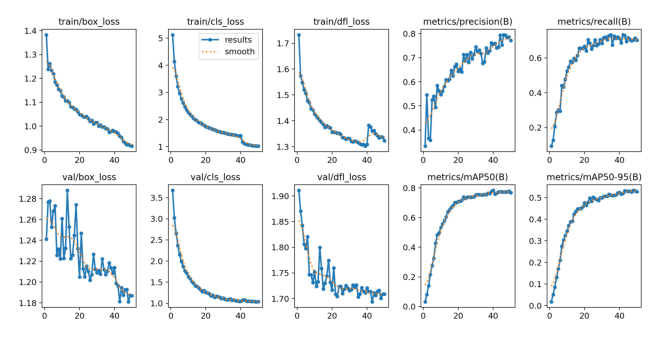

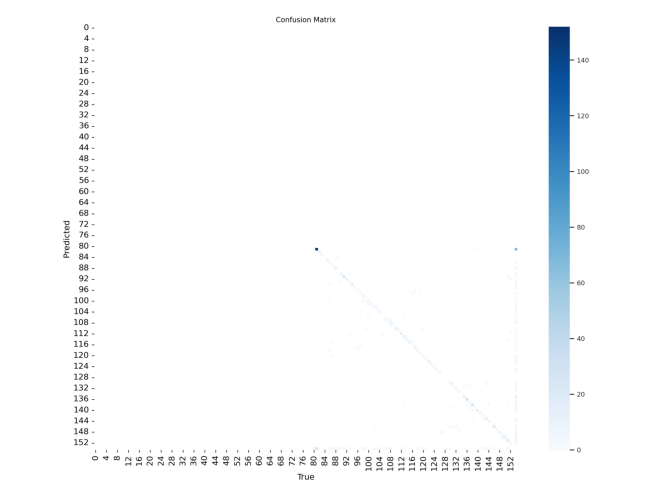

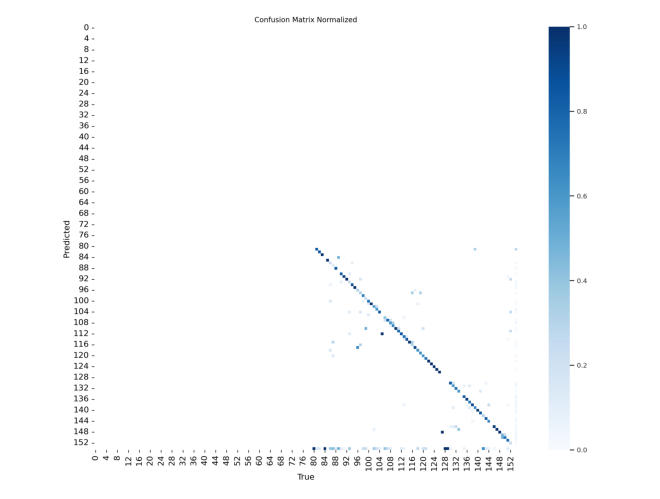

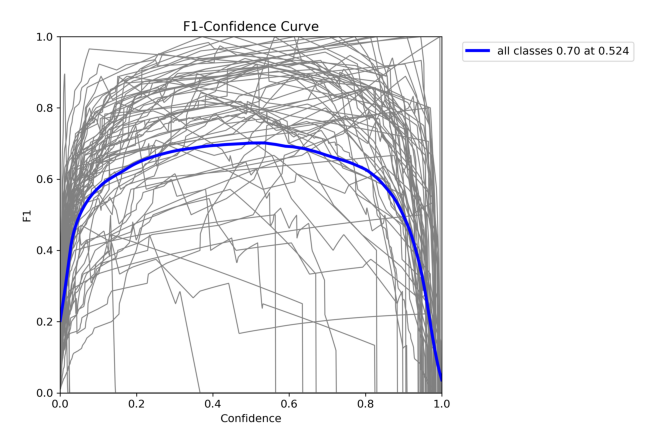

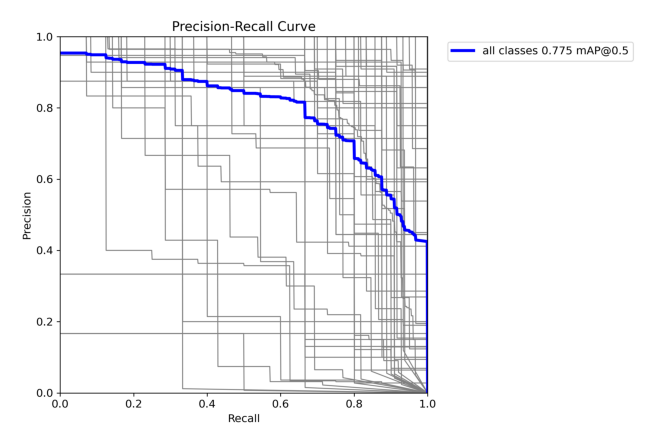

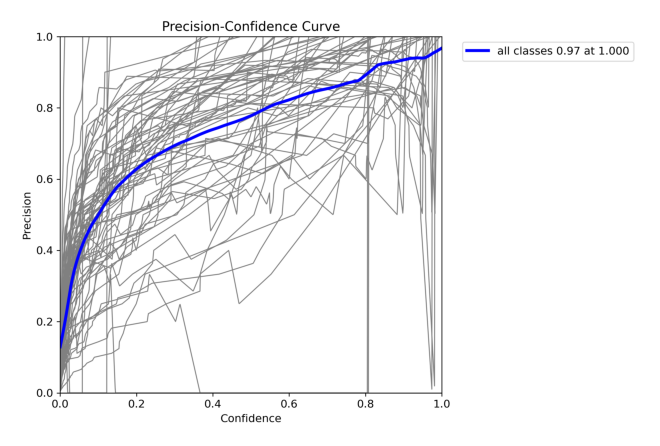

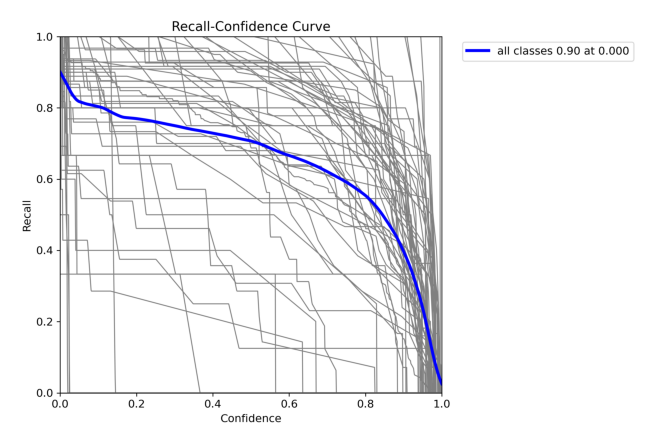

In [8]:
from ultralytics import YOLO


# Load Pretrained YOLO Model
model = YOLO("yolov8n.pt")  # Load YOLOv8n
import os
os.environ["RAY_DISABLE_IMPORT"] = "1"
# Modify the number of classes in the model
model.model.names = list(range(154))  # Set 154 class names
model.model.nc = 154  # Update class count

# Freeze the backbone manually by setting requires_grad=False for the layers
for module in model.model.model[:-1]:  # Exclude the final detection head layer
    for param in module.parameters():
        param.requires_grad = False  # Freeze the backbone layers

# Train on the new dataset
model.train(data="/kaggle/working/signboards/data.yaml", epochs=50, imgsz=640, batch=8)

# Save the extended model
model.save("yolov8m_signboard.pt")


In [9]:
task.close()

In [10]:
import shutil

# Define the folder path
folder_path = '/kaggle/working/runs'  # Replace with the correct path if necessary
zip_path = 'runs.zip'

# Create a zip file from the folder
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

# Output the path of the created zip file
print("saved")

saved
